# Financial Econometrics I: Project 
####    Lukáš Beran, Martin Konvičný
2022



**Table of Contents:**
- [1. Data Description](#1.-Data-description)
- [2. In-Sample Fit](#2.-In-Sample-Fit)
    - [ARMA-GARCH](#ARMA-GARCH)
    - [Realized GARCH](#Realized-GARCH)
    - [AR(1)-RV](#AR(1)-RV)
    - [HAR](#HAR)
    - [HAR-RS](#HAR-RS)
    - [HAR-RSkew-RKurt](#HAR-RSkew-RKurt)
    - [Visual Comparison of Fits](#Visual-Comparison-of-Fits)
- [3. Forecasts](#3.-Forecasts)
    - [ARMA-GARCH](#ARMA-GARCH:-Forecast)
    - [Realized GARCH](#Realized-GARCH:-Forecast)
    - [AR(1)-RV](#AR(1)-RV:-Forecast)
    - [HAR](#HAR:-Forecast)
    - [HAR-RS](#HAR-RS:-Forecast)
    - [HAR-RSkew-RKurt](#HAR-RSkew-RKurt:-Forecast)
- [4. Summary](#4.-Summary)

> **General information:** Form groups of two students. Project should be submitted to SIS in the module ”Study group roster” (Studijni mezivysledky) - Financial Econometrics I - Lecture - Empirical Project as a single file for the whole group, please include names of both students in the file name. Please use HTML generated from Jupyter notebook as a solution file. The solution should be in a form of empirical project with all comments, discussions as well as reproducible codes. Data for the homework are stored in the SIS as ”data project.zip”. ”data project.zip” contains 35 assets and each group was assigned one asset (see Table 1 on page 3) - for example Group Nr. 1 is going to analyze asset number 4 stored as ”4.RData”. Each ”.RData” file contains an xts file with
>- returns (ret),
>- realized volatility (RV),
>- positive realized semi-volatility (RV p),
>- negative realized semi-volatility (RV n),
>- realized skewness (RS),
>- realized kurtosis (RK).

In [167]:
library(xts) 
library(forecast)
library(rugarch)
library(FinTS)
library(tseries)
library(highfrequency)

Warning message:
“package ‘highfrequency’ was built under R version 4.0.5”


## 1. Data description
> Provide short summary of descriptive statistics, ACF plots and plots of data you are going to use.

In [2]:
load("/Users/Martin/Desktop/Škola/IES FSV UK/Letní 22/Financial Econometrics/Project/27.RData")
summary(ame)
head(ame)
tail(ame)

     Index                 ret                   RV          
 Min.   :2010-01-05   Min.   :-0.2527888   Min.   :0.003702  
 1st Qu.:2011-07-04   1st Qu.:-0.0068913   1st Qu.:0.008264  
 Median :2013-01-10   Median : 0.0010382   Median :0.010180  
 Mean   :2013-01-08   Mean   : 0.0007028   Mean   :0.011325  
 3rd Qu.:2014-07-14   3rd Qu.: 0.0083568   3rd Qu.:0.012886  
 Max.   :2016-01-22   Max.   : 0.2775808   Max.   :0.049148  
      RV_p               RV_n                RS                  RK        
 Min.   :0.002444   Min.   :0.001766   Min.   :-7.939322   Min.   : 2.238  
 1st Qu.:0.005751   1st Qu.:0.005484   1st Qu.:-0.554549   1st Qu.: 3.739  
 Median :0.007074   Median :0.007041   Median : 0.006623   Median : 4.859  
 Mean   :0.007977   Mean   :0.007865   Mean   : 0.039841   Mean   : 6.277  
 3rd Qu.:0.009153   3rd Qu.:0.009229   3rd Qu.: 0.642186   3rd Qu.: 6.975  
 Max.   :0.042707   Max.   :0.038658   Max.   : 5.614541   Max.   :67.984  

                    ret          RV        RV_p        RV_n          RS
2010-01-05  0.007531251 0.008311400 0.005147807 0.006525293 -0.88469865
2010-01-06 -0.003887968 0.007652631 0.005473142 0.005348596 -0.15415308
2010-01-07 -0.000258914 0.010277150 0.007367069 0.007165620  0.02089636
2010-01-08  0.001817146 0.011089641 0.009563948 0.005613469  1.34266461
2010-01-11  0.020280371 0.009687281 0.006460028 0.007218826 -0.65221257
2010-01-12 -0.002034404 0.010989402 0.006442287 0.008903027 -0.79359678
                 RK
2010-01-05 6.947967
2010-01-06 4.175595
2010-01-07 5.095962
2010-01-08 5.504840
2010-01-11 5.016081
2010-01-12 3.429952

                    ret         RV        RV_p        RV_n          RS       RK
2016-01-14 -0.036968597 0.01985208 0.013399463 0.014647847 -1.12159383 9.584569
2016-01-15  0.002338732 0.01594775 0.012424969 0.009997541  0.50847305 2.705181
2016-01-19  0.024946127 0.01665803 0.011053758 0.012462119 -0.17944438 2.889067
2016-01-20 -0.039917798 0.02337751 0.016420208 0.016639853 -0.26491515 4.940618
2016-01-21  0.002368430 0.02164599 0.015178155 0.015432845 -0.05964167 2.965381
2016-01-22  0.014087507 0.01312226 0.008973442 0.009574495  0.01960343 2.923045

We will work with a dataset from the period between 05/01/2010 and 22/01/2016. Based on the plots below, returns tend to exhibit volatility clustering in some periods. It indicates the presence of autoregressive conditional heteroskedasticity. Therefore, we may employ the GARCH model to estimate the time series.

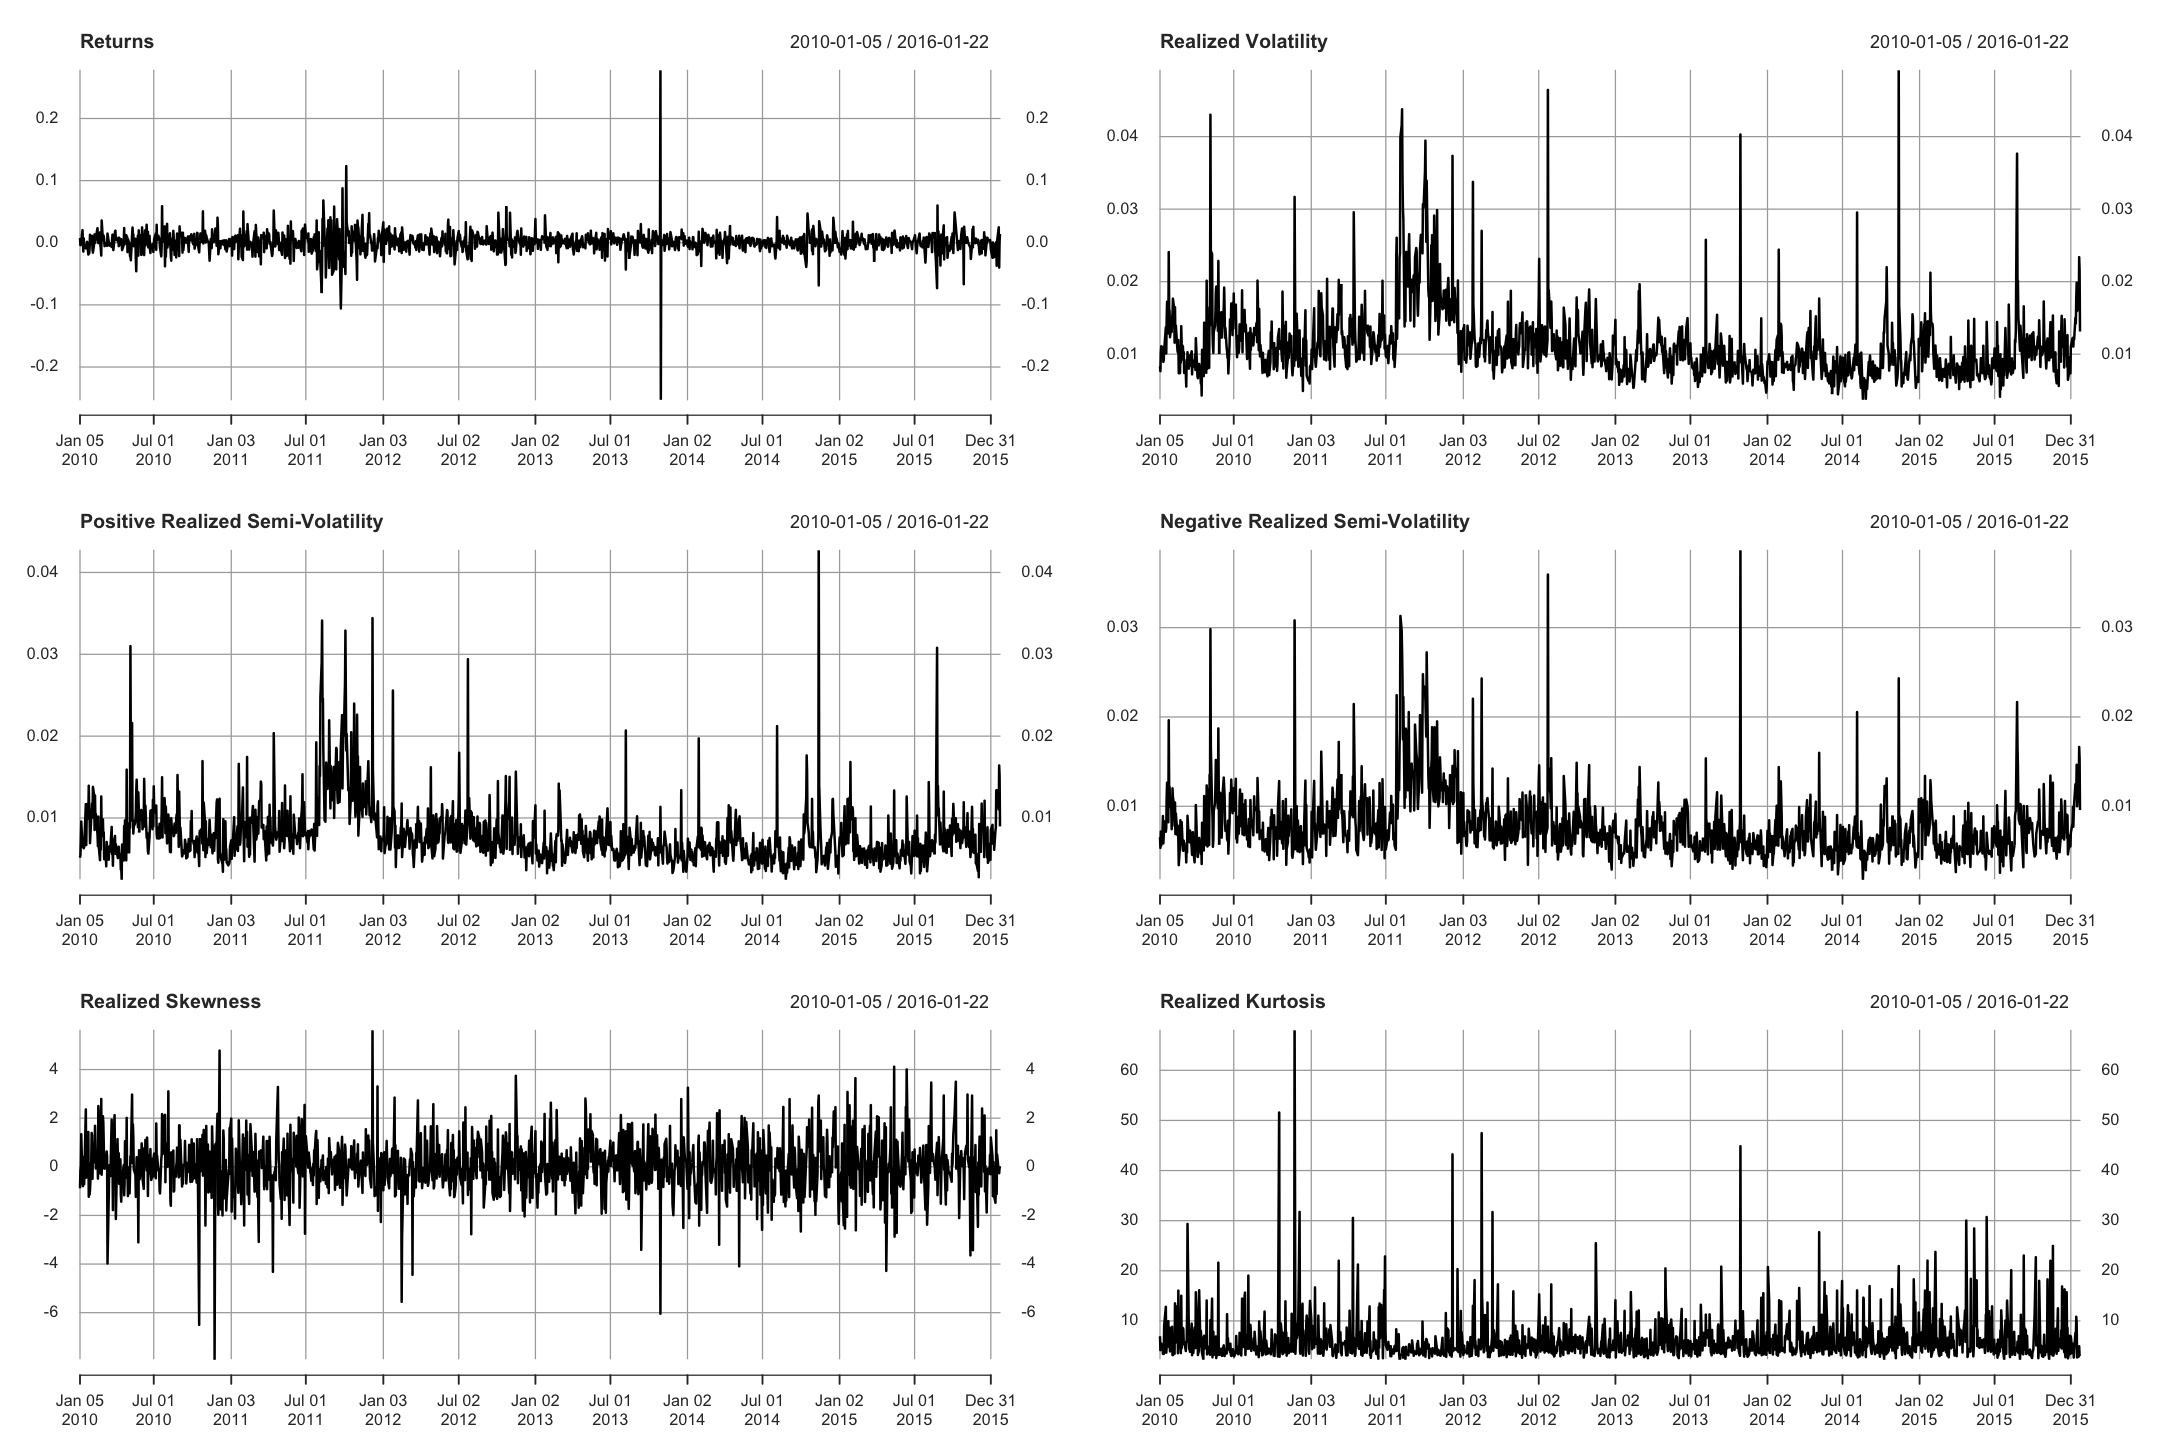

In [3]:
ret <- ame$ret # returns
RVol <- ame$RV # realized volatility
RVolP <- ame$RV_p # positive realized semi-volatility
RVolN <- ame$RV_n # negative realized semi-volatility
RS <- ame$RS # realized skewness
RK <- ame$RK # realized kurtosis

options(repr.plot.width = 18, repr.plot.height = 12)
par(mfrow = c(3, 2))
plot(ret, main = "Returns")
plot(RVol, main = "Realized Volatility")
plot(RVolP, main = "Positive Realized Semi-Volatility")
plot(RVolN, main = "Negative Realized Semi-Volatility")
plot(RS, main = "Realized Skewness")
plot(RK, main = "Realized Kurtosis")

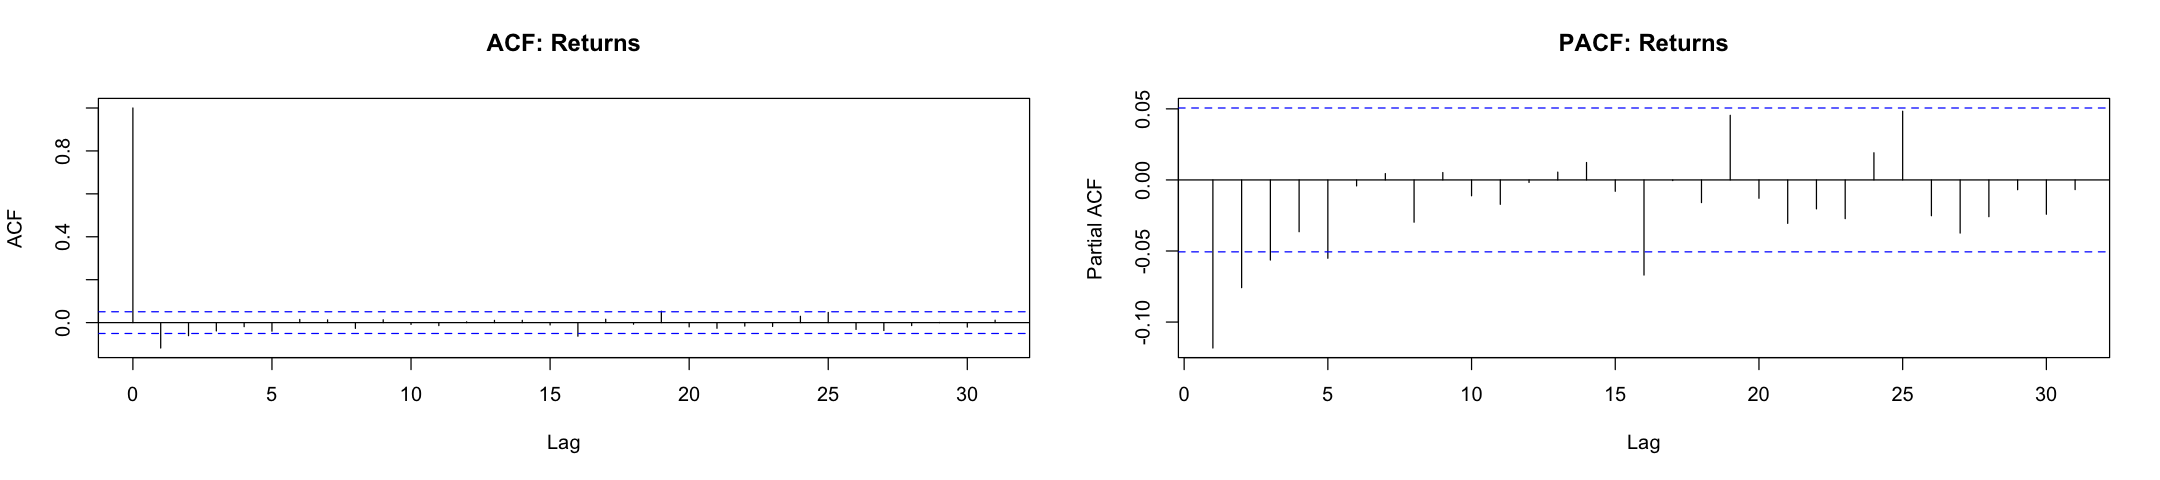

In [110]:
options(repr.plot.width = 18, repr.plot.height = 4)
par(mfrow = c(1, 2))
# returns
acf(ret, main = "ACF: Returns")
pacf(ret, main = "PACF: Returns")

ACF and PACF plots of returns indicate two things. Firstly, returns seem to be meet the stationary condition as ACF is decaying rapidly. Secondly, simple ARMA model should remove linear dependency in the data as there are a few significant lags.

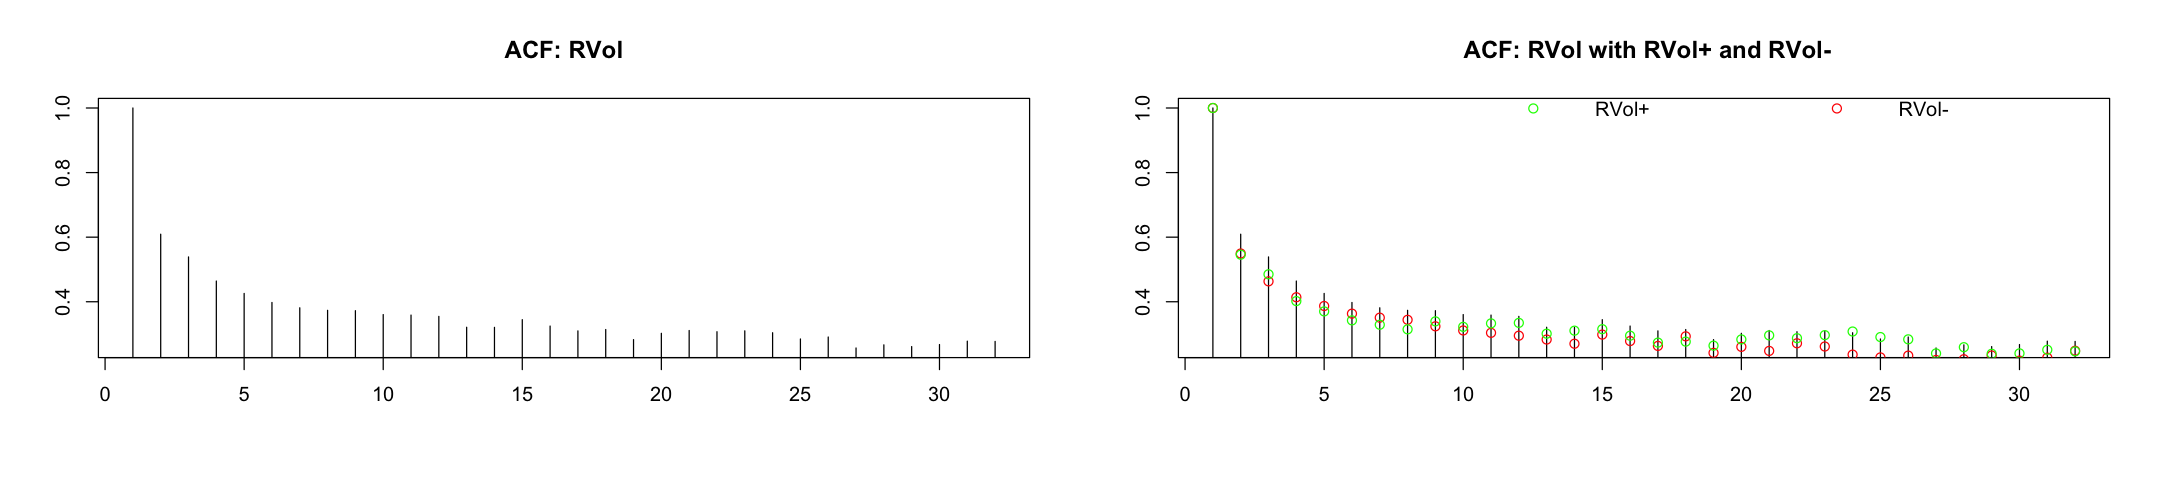

In [109]:
acf_rvol <- acf(RVol,plot = FALSE)$acf[,1,1] # realized volatility
acf_rvol_p <- acf(RVolP,plot = FALSE)$acf[,1,1] # positive realized semi-volatility
acf_rvol_n <- acf(RVolN,plot = FALSE)$acf[,1,1] # negative realized semi-volatility

par(mfrow = c(1, 2))
plot(acf_rvol, type = "h",ylab=NA,xlab=NA, main= "ACF: RVol")

plot(acf_rvol, type="h",ylab=NA,xlab=NA,  main = " ACF: RVol with RVol+ and RVol-")
points(acf_rvol_n,col="red")
points(acf_rvol_p,col="green")
legend("topright", legend = c('RVol+', 'RVol-'), ncol = 2,
       col = c('green', 'red'), pch = 1, bty = 'n')

The ACF of realized volatility is decaying slower compared to returns. It may indicate the presence of the long memory process in the time series. The similar pattern exhibits both positive and negative realized semi-volatilities. They may better capture asymmetries on the markets.

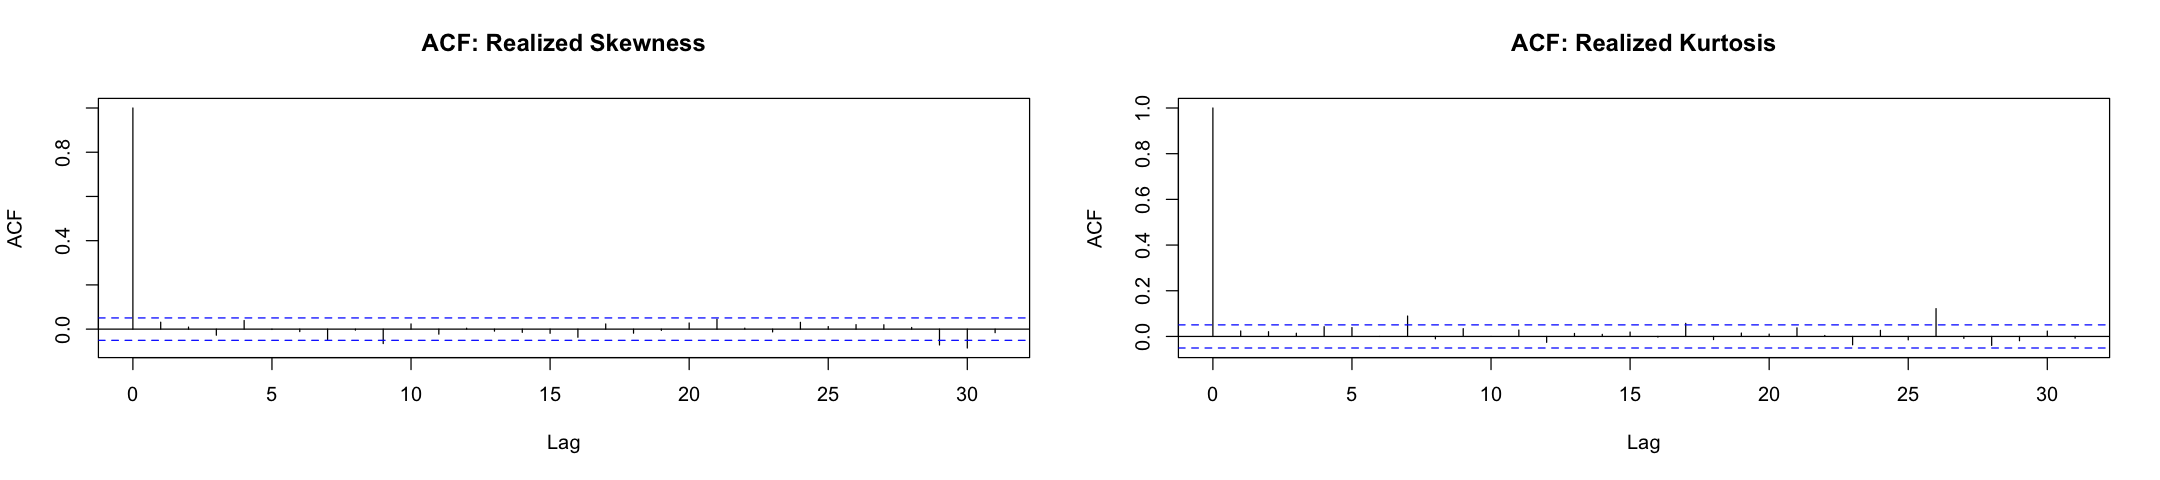

In [101]:
par(mfrow = c(1, 2))
# realized skewness
acf(RS, main = "ACF: Realized Skewness")
# realized kurtosis
acf(RK, main = "ACF: Realized Kurtosis")

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

## 2. In-Sample Fit 
> Estimate parameters of the following volatility models with full sample size: AR(1)-RV, HAR, HAR-RS, HAR-Rskew-RKurt, Realized GARCH, ARMA-GARCH. Discuss the fits and compare qualitative differences of the estimates shortly. Note you can simply use the plot comparing in-sample fits of all models.

### ARMA-GARCH

First of all, we would like to model the time series using the ARMA-GARCH model. The stationarity is a necessary condition for volatility modeling. Both ADF and KPSS tests suggest that returns do not have a unit root. Moreover, the ACF drops relatively quickly to zero (see the graph in the first section).

In [5]:
# Stationarity test
adf.test(ret)
kpss.test(ret)

Warning message in adf.test(ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ret
Dickey-Fuller = -12.347, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(ret):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  ret
KPSS Level = 0.23658, Truncation lag parameter = 7, p-value = 0.1


In [6]:
arma_00 <- Arima(ret, order = c(0, 0, 0))
arma_10 <- Arima(ret, order = c(1, 0, 0))
arma_01 <- Arima(ret, order = c(0, 0, 1))
arma_11 <- Arima(ret, order = c(1, 0, 1))
ic <- matrix(ncol = 2, nrow = 4)
colnames(ic) <- c('AIC', 'BIC')
rownames(ic) <- c('No linear dependence', 'AR(1)','MA(1)','ARMA(1,1)')

ic[1, 1] <- arma_00$aic
ic[1, 2] <- arma_00$bic
ic[2, 1] <- arma_10$aic
ic[2, 2] <- arma_10$bic
ic[3, 1] <- arma_01$aic
ic[3, 2] <- arma_01$bic
ic[4, 1] <- arma_11$aic
ic[4, 2] <- arma_11$bic
ic

,AIC,BIC
No linear dependence,-7745.374,-7734.748
AR(1),-7764.493,-7748.553
MA(1),-7768.238,-7752.298
"ARMA(1,1)",-7781.377,-7760.124


Series: ret 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1      ma1   mean
      0.5834  -0.7170  7e-04
s.e.  0.1003   0.0866  3e-04

sigma^2 = 0.0003259:  log likelihood = 3894.69
AIC=-7781.38   AICc=-7781.35   BIC=-7760.12

Series: ret 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
          ma1   mean
      -0.1401  7e-04
s.e.   0.0279  4e-04

sigma^2 = 0.000329:  log likelihood = 3887.12
AIC=-7768.24   AICc=-7768.22   BIC=-7752.3

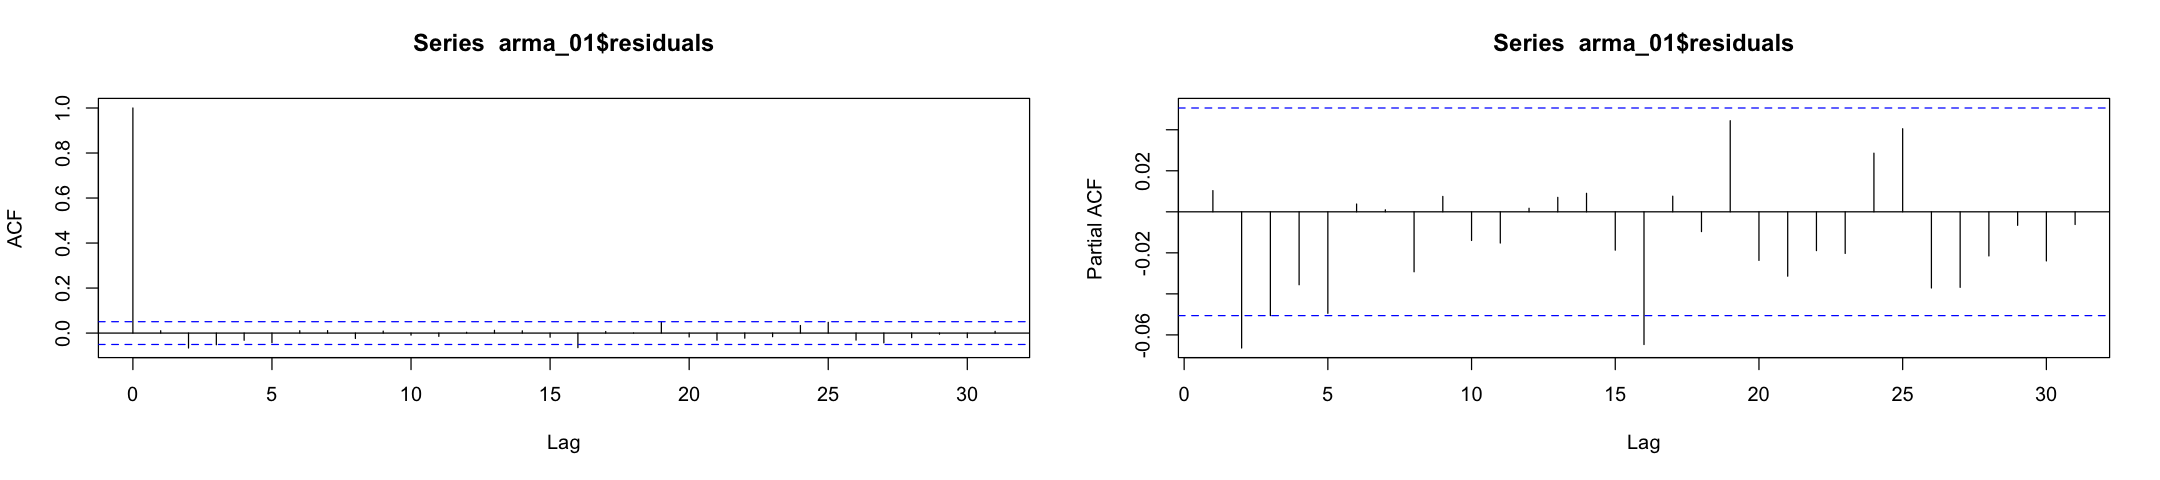

In [7]:
par(mfrow = c(1, 2))
# arma(1,1)
arma_11
# ma(1)
arma_01
options(repr.plot.width = 18, repr.plot.height = 4)
acf(arma_01$residuals)
pacf(arma_01$residuals)

With ACF and PACF plots of returns in mind, we initially estimate simple ARMA models. Based on the provided information criteria, MA(1) and ARMA(1,1) may be suitable models to remove linear dependencies in data. We choose the MA(1) model. Coefficients of ARMA(1,1) seem to be too high. They do not correspond to the values shown by ACF and PACF plots of returns. Furthermore, their values are relatively similar but with opposite signs. Residuals of the MA(1) model resemble the white noise, so there should be no significant linear dependence left.

Followingly, we display ACF and PACF plots of squared residuals and test whether there constant conditional variance using the ARCH-LM test. Its alternative hypothesis says there is conditional heteroskedasticity present in the residuals. In addition to the returns' plot, both methods indicate the ARCH effect is present in the data.


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  arma_01$residuals
Chi-squared = 332.33, df = 12, p-value < 2.2e-16


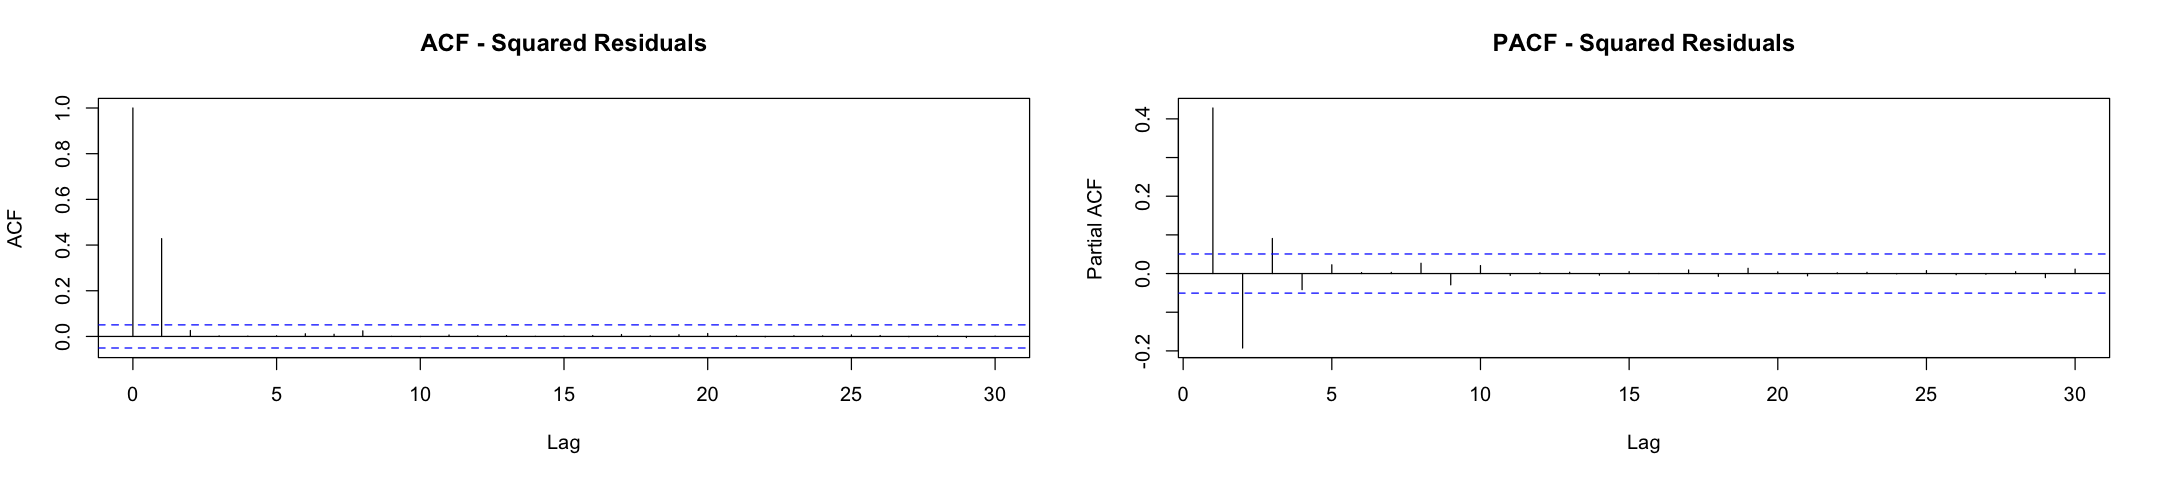

In [8]:
ArchTest(arma_01$residuals)

options(repr.plot.width = 18, repr.plot.height = 4)
par(mfrow = c(1, 2))
acf(arma_01$residuals^2, lag = 30, main = "ACF - Squared Residuals")
pacf(arma_01$residuals^2, lag = 30, main = "PACF - Squared Residuals")

We also plot the distribution of residuals and compare it to the normal distribution. The histogram seems to be skewed a little bit to the left. The residuals' distribution has heavy tails as well. To sum up, it does not fit the normal distribution very well. Hence, we use the ARMA-GARCH model with student t-distribution.

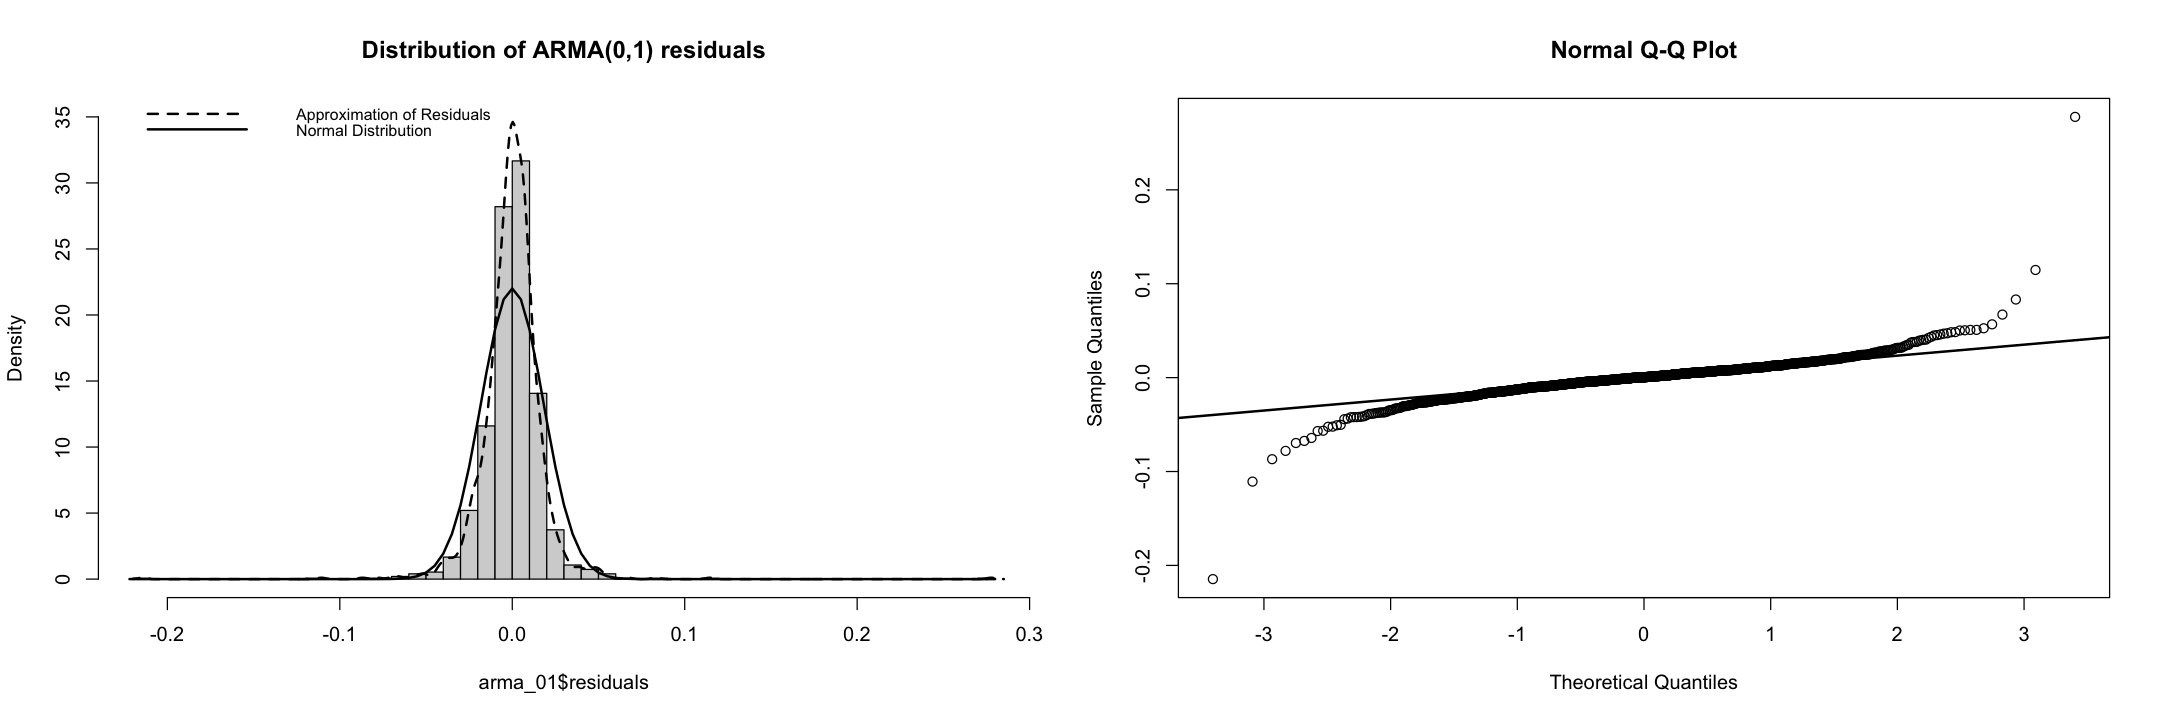

In [9]:
options(repr.plot.width = 18, repr.plot.height = 6)
par(mfrow = c(1, 2))
hist(arma_01$residuals, breaks = 60, prob = TRUE, ylim=c(0, 35), main = "Distribution of ARMA(0,1) residuals")
lines(density(arma_01$residuals, kernel = "gaussian"), col = "black", lty= "dashed", lwd = 2) # kernel density approximation
curve(dnorm(x, mean=mean(arma_01$residuals), sd=sd(arma_01$residuals)), lwd=2, add=TRUE, yaxt="n") # normal distribution
legend("topleft", legend = c("Approximation of Residuals", "Normal Distribution"), 
       lwd = 2, lty = c("dashed", "solid"), cex=0.8, bty = "n")

qqnorm(arma_01$residuals) 
qqline(arma_01$residuals, lwd = 2)

Firstly, we estimate the MA(1) - GARCH(1,1) model with normal distribution. All dependencies of higher order seem to be removed, but the Ljung-Box test on Standardized Residuals shows we could do better in terms of linear dependency.

The estimated model is specified followingly:
$$y_t = \mu + \phi_1 u_{t-1} +  u_t$$
$$u_t = \epsilon_t h_t^{1/2} $$
$$h_t = \alpha_0 + \alpha_1 u^2_{t-1} + \beta_1 h_{t-1}$$

In [10]:
armagarch_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 1)),
                         variance.model = list(model="sGARCH", garchOrder = c(1, 1))) 
armagarch <- ugarchfit(armagarch_spec, ret)
armagarch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000338    0.000000  3460.0284  0.00000
ma1    -0.129500    0.000037 -3460.0661  0.00000
omega   0.000000    0.000000     1.0124  0.31133
alpha1  0.052956    0.000015  3420.8669  0.00000
beta1   0.900646    0.000297  3028.4033  0.00000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000338    0.010938  0.030928  0.97533
ma1    -0.129500    4.186555 -0.030932  0.97532
omega   0.000000    0.031847  0.000011  0.99999
alpha1  0.052956    1.734332  0.030534  0.97564
beta1   0.900646   28.315632  0.031807  0.97463

LogLikelihood : 3926.161 

Information Criteria
-----------------------------------

As a result, we estimate the MA(1) - GARCH(1,1) model with student t- distribution. Using this specification, we do not reject the null hypothesis of the Ljung Box test on standardized residuals. Furthermore, the values of all information criteria decrease, so we have a better fit. By adding the shape parameter to estimate, the MA(1) term turns out to be not significantly different from zero.

In [11]:
armagarcht_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 1)),
                         variance.model = list(model="sGARCH", garchOrder = c(1, 1)), distribution.model = 'std') 
armagarcht <- ugarchfit(armagarcht_spec, ret)
armagarcht


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000992    0.000304   3.2687 0.001081
ma1     0.021821    0.027965   0.7803 0.435212
omega   0.000036    0.000010   3.6394 0.000273
alpha1  0.264986    0.055763   4.7520 0.000002
beta1   0.621481    0.068666   9.0507 0.000000
shape   4.343653    0.487966   8.9016 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000992    0.000308  3.21958 0.001284
ma1     0.021821    0.026441  0.82528 0.409211
omega   0.000036    0.000022  1.63701 0.101630
alpha1  0.264986    0.088925  2.97988 0.002884
beta1   0.621481    0.147794  4.20504 0.000026
shape   4.343653    0.689199  6.30247 0.000000

LogLikel

Lastly, we try to avoid overfitting to have a model with good prediction power. Hence, we do not include any AR or MA term in the mean equation. We estimate only GARCH(1,1)-t model. The tests suggest there is no dependency of first or second order left. Additionally, we improve the fit in terms of information criteria again.

The estimated model can be written in general way:
$$y_t = \mu + u_t$$
$$u_t = \epsilon_t h_t^{1/2} \sim f_v$$
$$h_t = \alpha_0 + \alpha_1 u^2_{t-1} + \beta_1 h_{t-1}$$

In [12]:
ArchTest(ret)

garcht_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                         variance.model = list(model="sGARCH", garchOrder = c(1, 1)), distribution.model = 'std') 
garcht <- ugarchfit(garcht_spec, ret)
garcht


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  ret
Chi-squared = 458.11, df = 12, p-value < 2.2e-16



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000997    0.000298   3.3443 0.000825
omega   0.000035    0.000010   3.6399 0.000273
alpha1  0.262873    0.055126   4.7686 0.000002
beta1   0.624247    0.068182   9.1556 0.000000
shape   4.371451    0.490975   8.9036 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000997    0.000308   3.2401 0.001195
omega   0.000035    0.000021   1.6383 0.101349
alpha1  0.262873    0.087949   2.9889 0.002800
beta1   0.624247    0.146656   4.2565 0.000021
shape   4.371451    0.695251   6.2876 0.000000

LogLikelihood : 4314.665 

Information Criteria
------------------------------------
                 

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### Realized GARCH

There is another solution to improve the benchmark model, GARCH. We can include realized volatility into the volatility equation. Besides, we need to specify the measurement error equation, as realized volatility is measured with some error. The model takes the following form:
$$r_t = h_t^{1/2}z_t$$
$$\ln(h_t) = \omega + \beta(h_{t-1}) + \gamma \ln(x_{t-1})$$
$$\ln(x_t) = \xi + \psi \ln(h_t) + u_t,$$

where $x_t$ is realized measure of volatility. The Realized GARCH model might not sufficient for explaining the long memory, which is an important feature of volatility. Long memory refers to the fact that the autocorrelation of the squared or absolute returns of financial assets decay at a slow rate.

In [13]:
realgarch_spec <- ugarchspec(variance.model = list(model = 'realGARCH', garchOrder = c(1, 1)), 
    mean.model = list(armaOrder=c(0, 0), include.mean=TRUE))
realgarch <- ugarchfit(realgarch_spec, ret, solver = 'hybrid', realizedVol = RVol) # square root?

In [14]:
realgarch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: realGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000731    0.000380  1.92409 0.054344
omega   0.013011    0.266393  0.04884 0.961047
alpha1  1.000000    0.079643 12.55598 0.000000
beta1   0.452955    0.031406 14.42240 0.000000
eta11  -0.061629    0.007312 -8.42863 0.000000
eta21   0.007035    0.000755  9.31208 0.000000
delta   0.432983    0.027787 15.58209 0.000000
lambda  0.249968    0.004588 54.48456 0.000000
xi     -0.959059    0.228449 -4.19813 0.000027

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000731    0.000390  1.875549 0.060717
omega   0.013011    0.445220  0.029223 0.976687
alpha1  1.000000    0.253461  3.945388 0.000080
b

By including realized volatility, we improve a fit in terms of information criteria compared to the standard GARCH(1,1) but realized GARCH does not outperform the GARCH(1,1) with student t-distribution. In addition, tests on standardized and standardized squared residuals suggest some dependencies remain there.

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### AR(1)-RV

We try to model realized volatility with a first-order autoregressive process. On the other hand, we might suspect long memory based on the ACF of realized volatility shown in the first section of the project. The model has the following form:
$$RVol_t = \alpha + \beta_1 RVol_{t-1} + u_t,$$
where $RVol_t = \sqrt{RV_t}$

In [15]:
TT <- length(RVol)
ar1_rv <- lm(RVol[2:TT] ~ RVol[1:(TT - 1)]) 
summary(ar1_rv)


Call:
lm(formula = RVol[2:TT] ~ RVol[1:(TT - 1)])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.017637 -0.002061 -0.000564  0.001365  0.039325 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0044288  0.0002534   17.48   <2e-16 ***
RVol[1:(TT - 1)] 0.6091626  0.0204943   29.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003939 on 1497 degrees of freedom
Multiple R-squared:  0.3711,	Adjusted R-squared:  0.3707 
F-statistic: 883.5 on 1 and 1497 DF,  p-value: < 2.2e-16


--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### HAR

The long memory process may be captured by a short-memory specification with an extended structure of lags, according to Corsi (2009). It approximates the long memory process. The model arises from the idea of a heterogeneous investment horizon of traders, for instance, one day, working week (5 days), or month (22 days). As a result, we apply the following model to the realized volatility:

$$RVol_t = \alpha + \beta_1 RVol_{t-1} + \beta_2 RVol_{t-1}^{(5)} + \beta_3 RVol_{t-1}^{(22)} + u_t,$$
where $RVol_t = \sqrt{RV_t}$

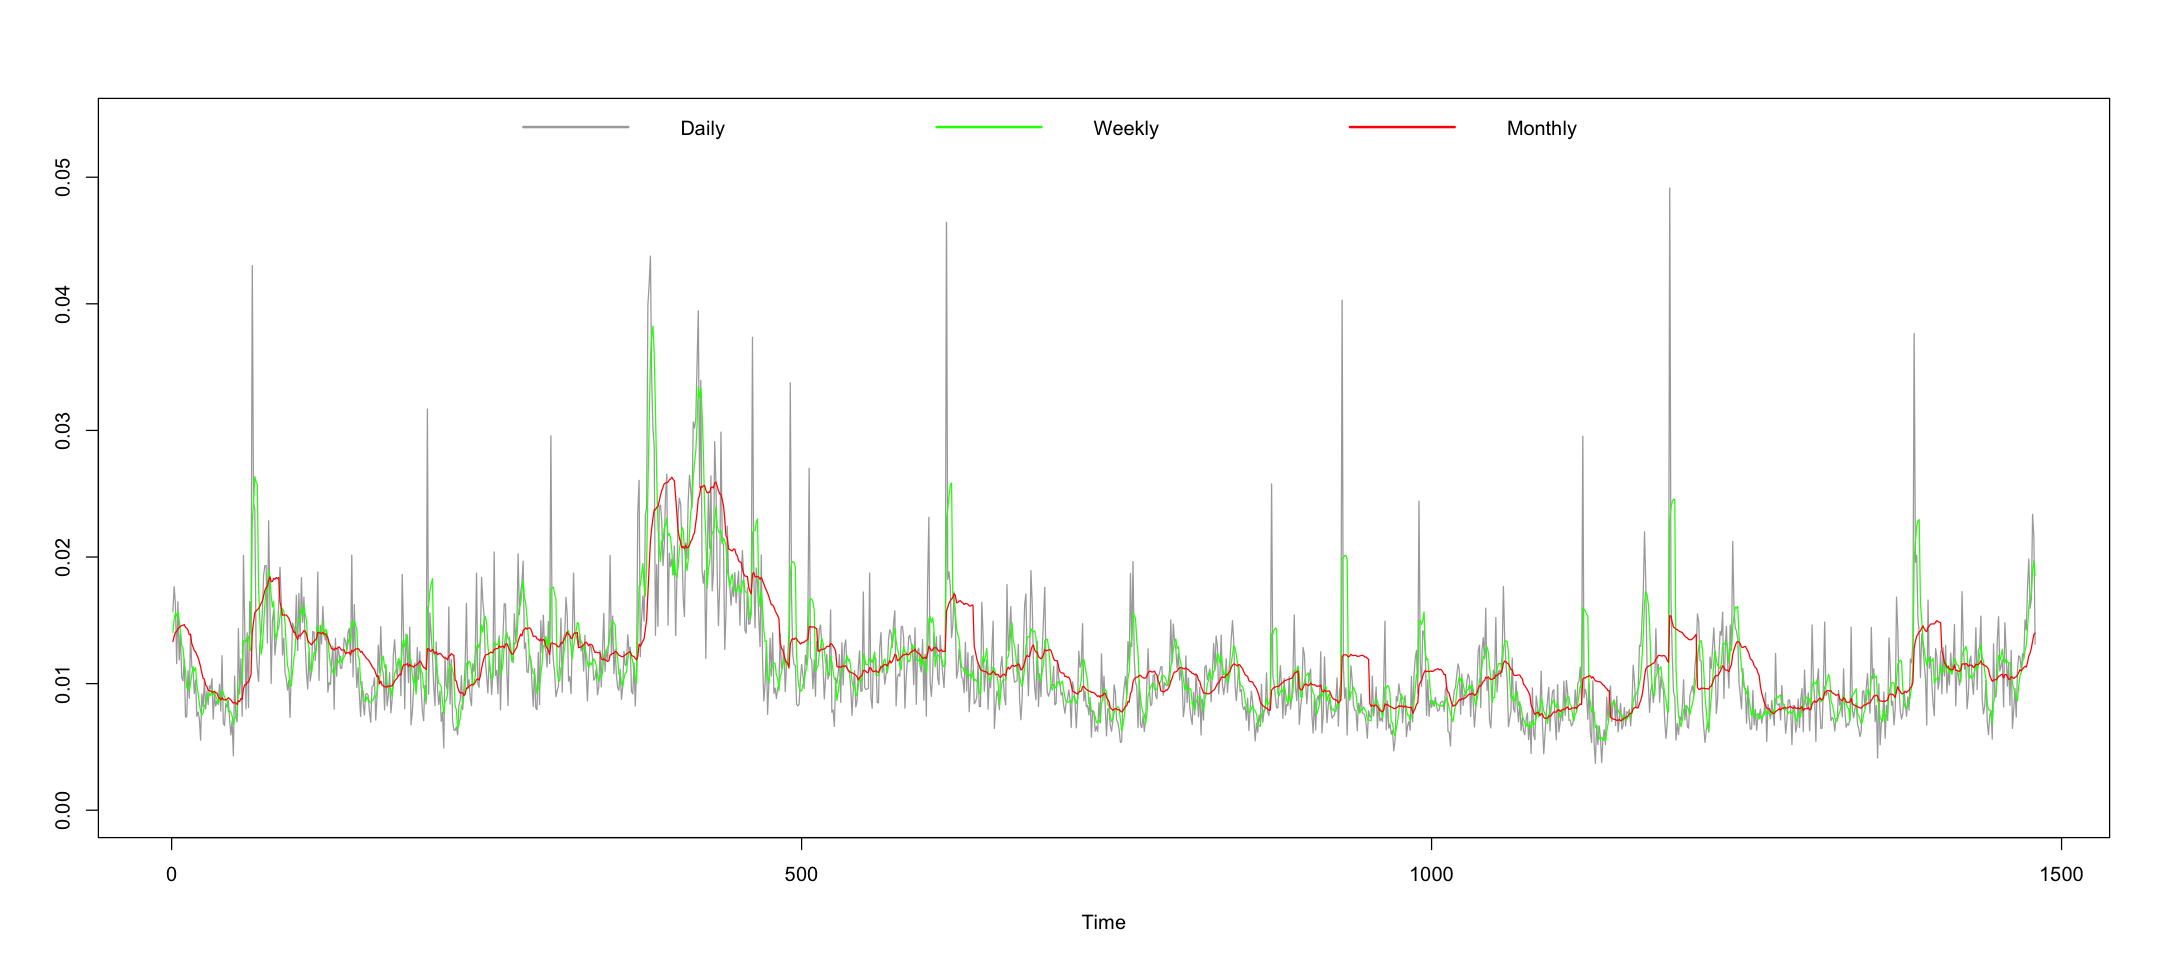

In [225]:
# Creating RV to create h-periods
RV <- RVol^2 

RV5 <- unlist(lapply(lapply(1:(TT - 4), function (t) {return(RV[t:(t + 4)])}), mean)) # RVol for week
RV22 <- unlist(lapply(lapply(1:(TT - 21), function (t) {return(RV[t:(t + 21)])}), mean)) # RVol for month

RVol5 <- sqrt(RV5)
RVol22 <- sqrt(RV22)

T5 <- length(RVol5)
T22 <- length(RVol22)

plot.ts(RVol[22:TT], ylab = NA, col = 'darkgray', ylim = c(0, max(RVol) * 1.1))
lines(RVol5[18:T5], col = 'green') 
lines(RVol22, col = 'red') 
legend("top", ncol = 3, legend = c('Daily', 'Weekly', 'Monthly'),
       col = c('darkgray', 'green', 'red'), lwd = 2, bty = 'n')

In [226]:
har <- lm(RVol[23:TT] ~ RVol[22:(TT - 1)] + RVol5[18:(T5 - 1)] + RVol22[1:(T22 - 1)]) 
summary(har)


Call:
lm(formula = RVol[23:TT] ~ RVol[22:(TT - 1)] + RVol5[18:(T5 - 
    1)] + RVol22[1:(T22 - 1)])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.012085 -0.001961 -0.000512  0.001310  0.039440 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.0016250  0.0003447   4.714 2.66e-06 ***
RVol[22:(TT - 1)]   0.3709232  0.0308869  12.009  < 2e-16 ***
RVol5[18:(T5 - 1)]  0.1665622  0.0463327   3.595 0.000335 ***
RVol22[1:(T22 - 1)] 0.3005356  0.0447587   6.715 2.68e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003772 on 1474 degrees of freedom
Multiple R-squared:  0.427,	Adjusted R-squared:  0.4258 
F-statistic: 366.1 on 3 and 1474 DF,  p-value: < 2.2e-16


--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### HAR-RS

We can develop the HAR model further. The Prospect Theory proposed by Kahneman and Tversky says that we react differently to positive and negative news. There is an asymmetry. Financial markets are no exception. Therefore, we can replace one-day lag ($RVol_{t-1}$) with positive ($RSVol^+_{t-1}$) and negative realized semi-volatility ($RSVol^-_{t-1}$) to obtain a better fit. The model looks as follows:

$$RVol_t = \alpha  + \beta_1 RSVol^+_{t-1} + \beta_2 RSVol^-_{t-1} +\beta_3 RVol_{t-1}^{(5)} + \beta_4 RVol_{t-1}^{(22)} +u_t$$

If there is no new information, $\beta_1 = \beta_2$ will equal to $\beta_1$ from the HAR model (the previously estimated model) as there is no impact to examine.

In [227]:
har_rs <- lm(RVol[23:TT] ~ RVolP[22:(TT - 1)] + RVolN[22:(TT - 1)] + RVol5[18:(T5 - 1)] + RVol22[1:(T22 - 1)]) 
summary(har_rs)


Call:
lm(formula = RVol[23:TT] ~ RVolP[22:(TT - 1)] + RVolN[22:(TT - 
    1)] + RVol5[18:(T5 - 1)] + RVol22[1:(T22 - 1)])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.012945 -0.001961 -0.000483  0.001276  0.039719 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.0016070  0.0003431   4.684 3.08e-06 ***
RVolP[22:(TT - 1)]  0.1970476  0.0431671   4.565 5.42e-06 ***
RVolN[22:(TT - 1)]  0.3576866  0.0416917   8.579  < 2e-16 ***
RVol5[18:(T5 - 1)]  0.1573757  0.0462363   3.404 0.000683 ***
RVol22[1:(T22 - 1)] 0.2955577  0.0445503   6.634 4.57e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003753 on 1473 degrees of freedom
Multiple R-squared:  0.433,	Adjusted R-squared:  0.4315 
F-statistic: 281.2 on 4 and 1473 DF,  p-value: < 2.2e-16


--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### HAR-RSkew-RKurt

Lastly, we can add lags for higher-order realized moments into the equation. On the one hand, realized kurtosis may help capture jumps in the series. The high values of kurtosis suggest the presence of jumps. On the other hand, the period of high skewness reflects the period of high kurtosis because of jumps. The extended equation looks as follows:

$$RVol_t = \alpha  + \beta_1 RVol_{t-1} + \beta_2 RVol_{t-1}^{(5)} + \beta_3 RVol_{t-1}^{(22)} + \beta_4 RKurt_{t-1} + \beta_5 RSkew_{t-1} + u_t.$$

In [228]:
har_rskew_rkurt<-lm(RVol[23:TT] ~ RVol[22:(TT - 1)] + RVol5[18:(T5 - 1)] + RVol22[1:(T22 - 1)] + 
             RK[22:(TT - 1)] + RS[22:(TT - 1)])
summary(har_rskew_rkurt)


Call:
lm(formula = RVol[23:TT] ~ RVol[22:(TT - 1)] + RVol5[18:(T5 - 
    1)] + RVol22[1:(T22 - 1)] + RK[22:(TT - 1)] + RS[22:(TT - 
    1)])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.011795 -0.001992 -0.000454  0.001348  0.041273 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          2.656e-03  3.708e-04   7.163 1.25e-12 ***
RVol[22:(TT - 1)]    4.280e-01  3.159e-02  13.551  < 2e-16 ***
RVol5[18:(T5 - 1)]   1.434e-01  4.578e-02   3.133  0.00176 ** 
RVol22[1:(T22 - 1)]  2.602e-01  4.447e-02   5.851 6.02e-09 ***
RK[22:(TT - 1)]     -1.478e-04  2.138e-05  -6.914 7.01e-12 ***
RS[22:(TT - 1)]     -5.997e-05  8.468e-05  -0.708  0.47897    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003714 on 1472 degrees of freedom
Multiple R-squared:  0.445,	Adjusted R-squared:  0.4431 
F-statistic: 236.1 on 5 and 1472 DF,  p-value: < 2.2e-16


To summarize fits of all (heterogeneous) autoregressive models, HAR model with realized skewness and kurtosis is the best performer in terms of $R^2$. All coefficients are significantly different from zero, except for the realized skewness, as jumps are adequately explained by realized kurtosis.

The goodness of fit improves as we include the cascade structure of lags and realized semi-volatility into the equation. It implies that adding weekly and monthly lags can approximate the long memory process in realized volatility as their coefficients are statistically significant. Additionally, financial markets respond differently to positive and negative news. The coefficients for positive and negative semi-volatility differ relatively a lot.

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### Visual Comparison of Fits

In [199]:
tail(merge(har$fitted.values, ar1_rv$fitted.values, har_rs$fitted.values, har_rskew_rkurt$fitted.values, RVol),5)

           har.fitted.values ar1_rv.fitted.values har_rs.fitted.values
2016-01-15        0.01545660           0.01652199           0.01572917
2016-01-19        0.01437307           0.01414362           0.01422019
2016-01-20        0.01480972           0.01457630           0.01501627
2016-01-21        0.01766305           0.01866955           0.01789019
2016-01-22        0.01738543           0.01761478           0.01757213
           har_rskew_rkurt.fitted.values         RV
2016-01-15                    0.01539372 0.01594775
2016-01-19                    0.01489402 0.01665803
2016-01-20                    0.01536750 0.02337751
2016-01-21                    0.01825175 0.02164599
2016-01-22                    0.01809293 0.01312226

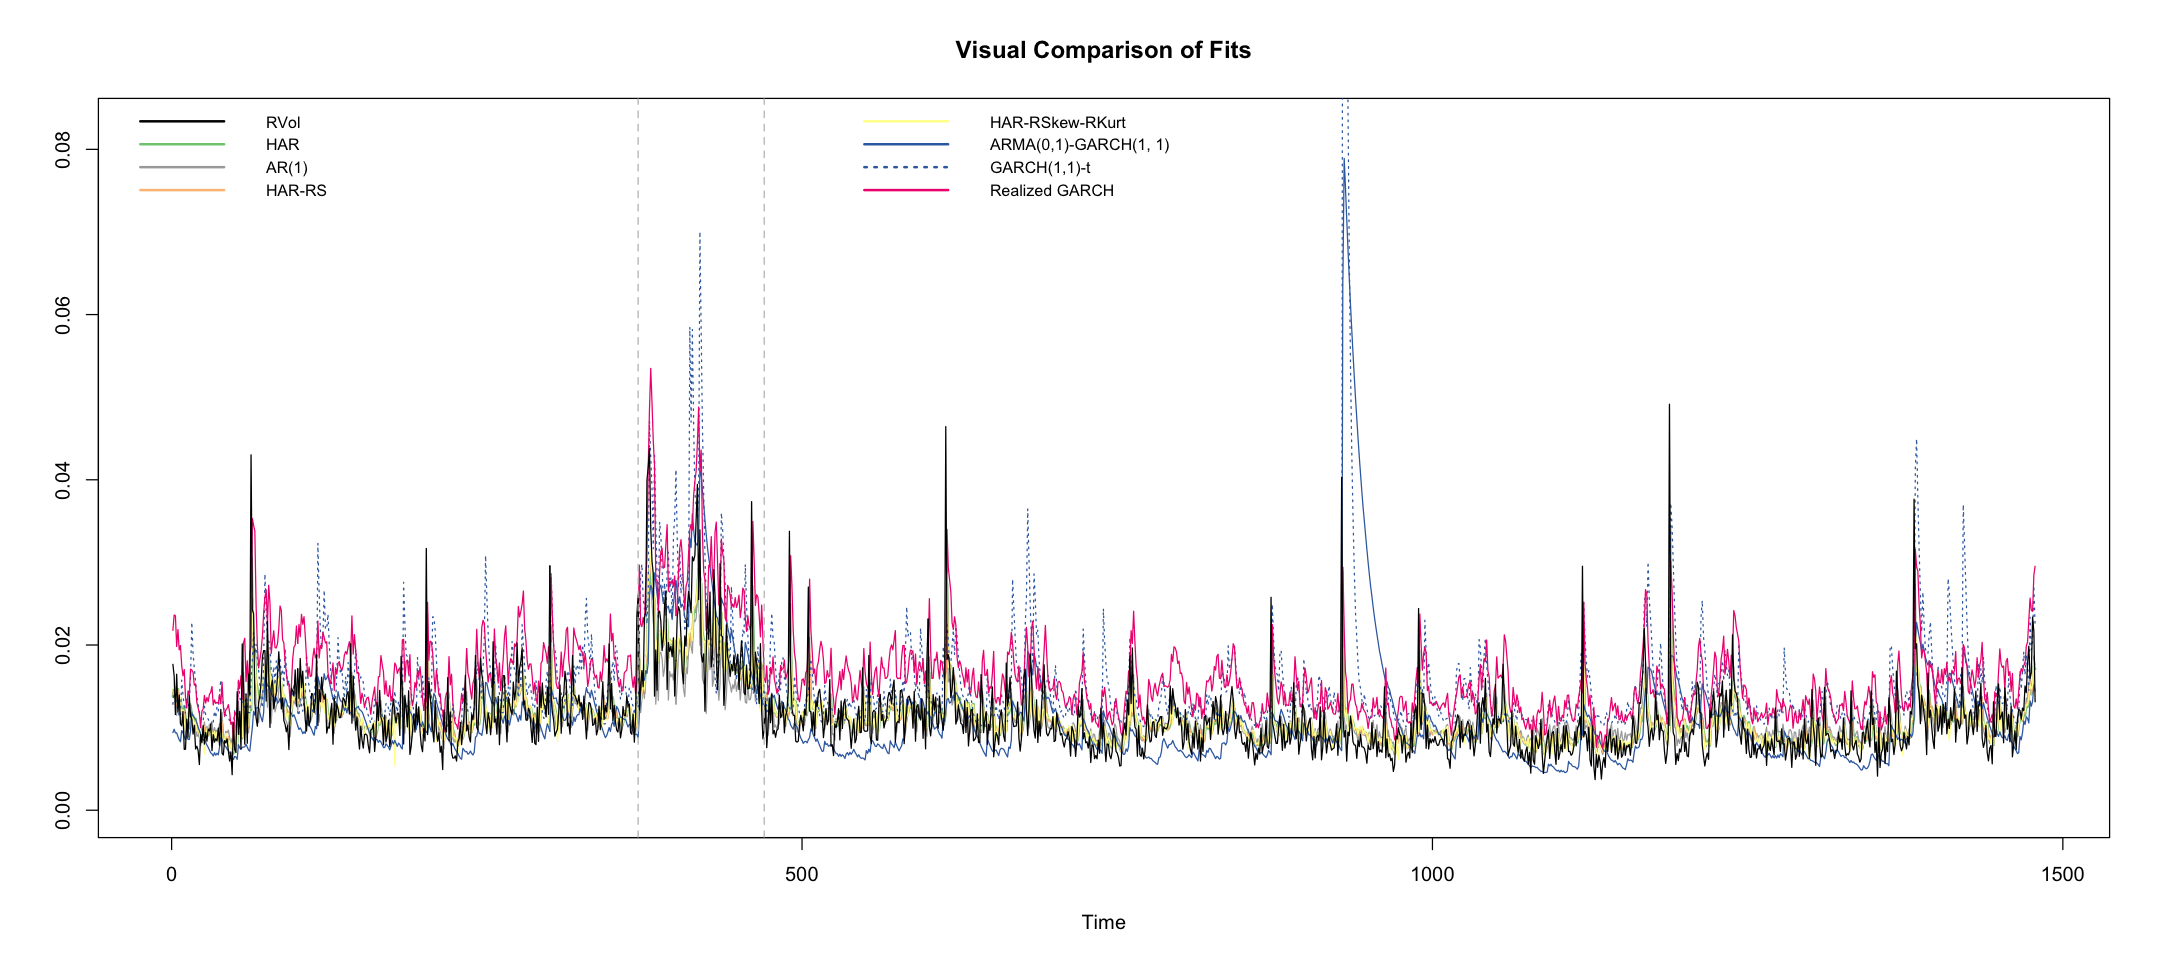

In [229]:
options(repr.plot.width = 18, repr.plot.height = 8)
plot.ts(har$fitted.values, ylab = NA, lwd = 2, col = '#7FC97F', main = "Visual Comparison of Fits",
        ylim = c(0, 1.05 * max(max(har$fitted.values), max(armagarch@fit$sigma))))
lines(ts(ar1_rv$fitted.values[23:TT-1]),col = "darkgray")
lines(ts(har_rs$fitted.values),col = "#FDC086")
lines(ts(har_rskew_rkurt$fitted.values),col = "#FFFF99")
lines(armagarch@fit$sigma[23:TT], col = '#386CB0')
lines(garcht@fit$sigma[23:TT], col = '#386CB0', lty = "dotted")
lines(realgarch@fit$sigma[23:TT], col = '#F0027F')
lines(ts(RVol[23:TT]), col = "black")
abline(v=c(370,470), col="gray", lty="dashed")
legend("topleft", ncol = 2, 
       legend = c("RVol", "HAR", "AR(1)", "HAR-RS", "HAR-RSkew-RKurt", 'ARMA(0,1)-GARCH(1, 1)', "GARCH(1,1)-t", "Realized GARCH"),
       col = c("black","#7FC97F",'darkgray', '#FDC086',"#FFFF99", "#386CB0", "#386CB0", "#F0027F"), 
       lty = c("solid","solid", "solid","solid","solid", "solid", "dotted", "solid"), lwd = 2, bty = 'n', cex = 0.8)

We plot fitted values of all relevant estimated models and compare them to the observed realized volatility. The published graphs are quite messy, but some patterns are visible. To gain better insight into the fits of models, we have decided to display a period of higher realized variance between the 370th and the 470th observation (highlighted by two vertical dotted gray lines) in the separate plot below as we can better examine differrences among models at the time of increased volatility.

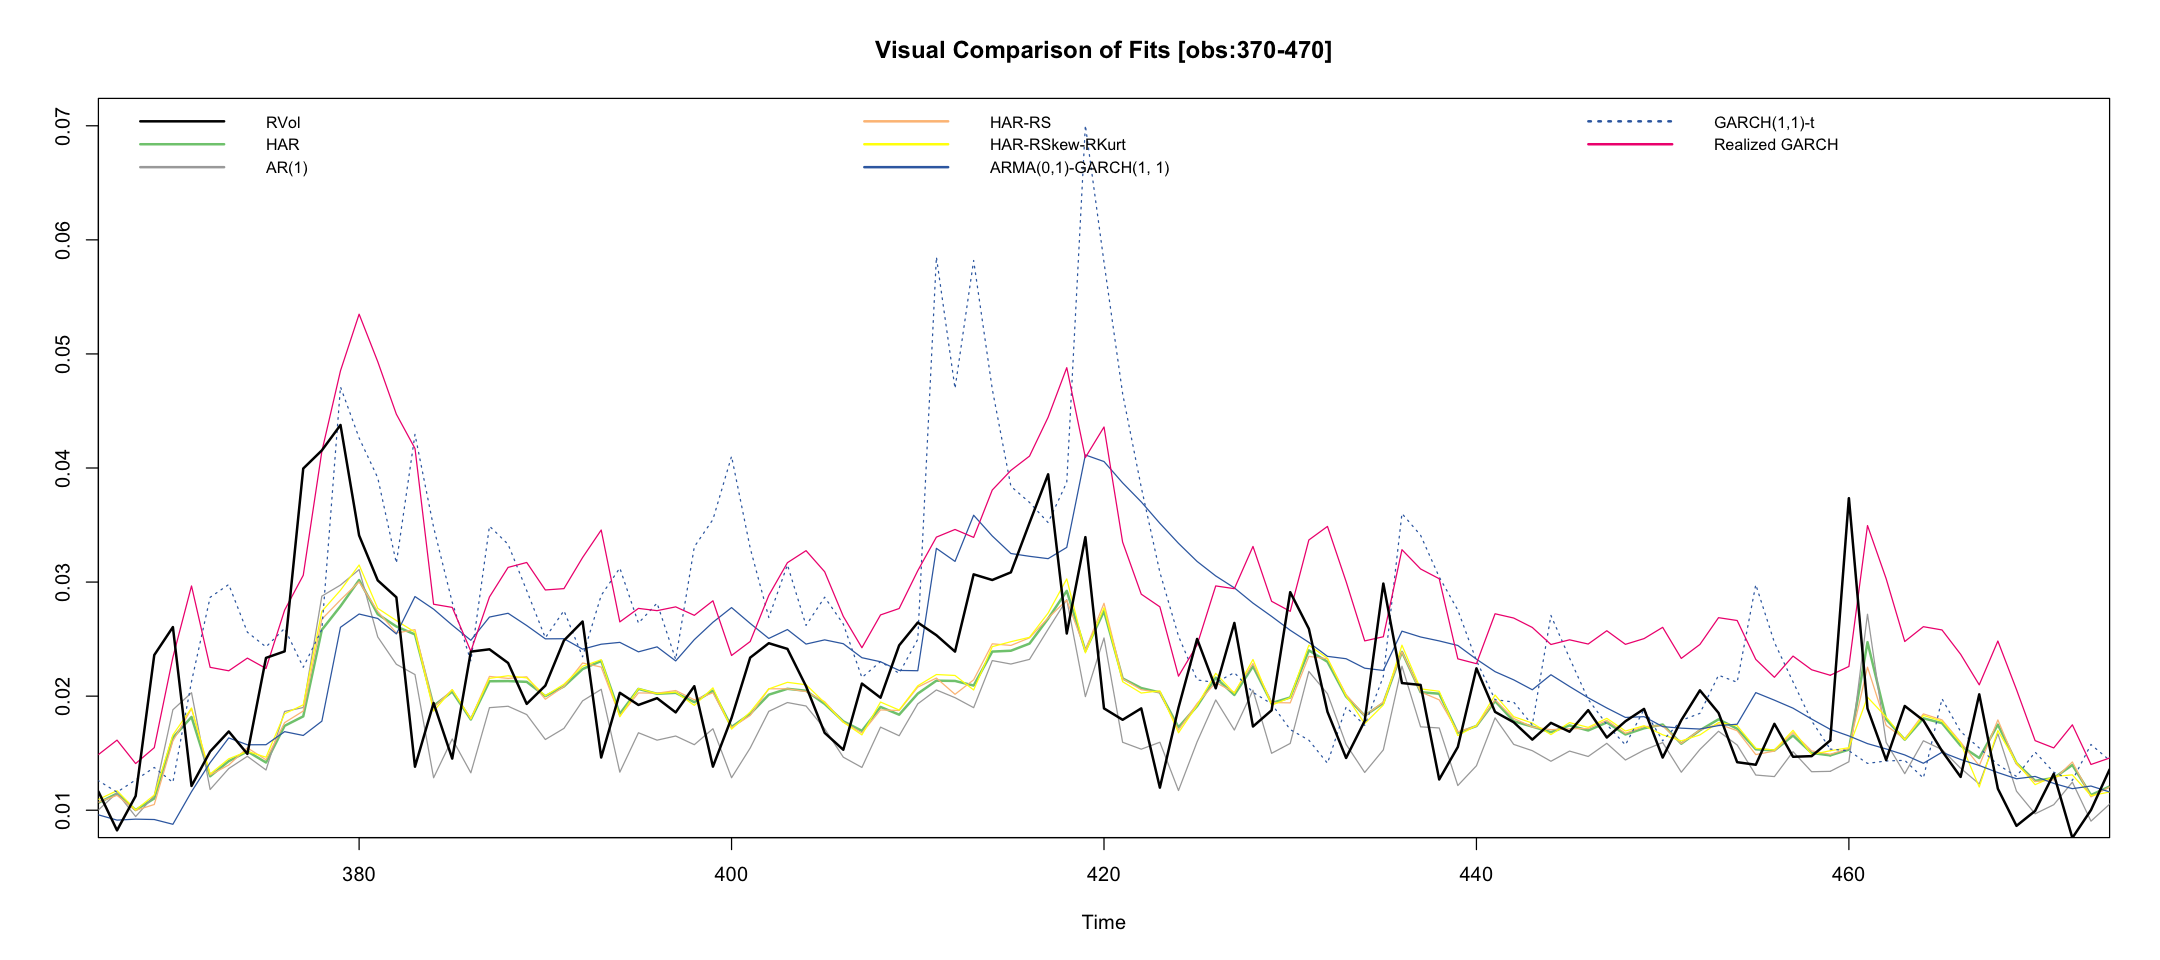

In [230]:
plot.ts(har$fitted.values, ylab = NA, lwd = 2, col = '#7FC97F', xlim = c(370,470), main = "Visual Comparison of Fits [obs:370-470]",
        ylim = c(0.01, 0.07))
lines(ts(ar1_rv$fitted.values[23:TT-1]),col = "darkgray")
lines(ts(har_rs$fitted.values),col = "#FDC086")
lines(ts(har_rskew_rkurt$fitted.values),col = "yellow")
lines(armagarch@fit$sigma[23:TT], col = '#386CB0')
lines(garcht@fit$sigma[23:TT], col = '#386CB0', lty = "dotted")
lines(realgarch@fit$sigma[23:TT], col = '#F0027F')
lines(ts(RVol[23:TT]), col = "black", lwd = 2)
legend("topleft", ncol = 3, 
       legend = c("RVol", "HAR", "AR(1)", "HAR-RS", "HAR-RSkew-RKurt", 'ARMA(0,1)-GARCH(1, 1)', "GARCH(1,1)-t", "Realized GARCH"),
       col = c("black","#7FC97F",'darkgray', '#FDC086',"yellow", "#386CB0", "#386CB0", "#F0027F"), 
       lty = c("solid","solid", "solid","solid","solid", "solid", "dotted", "solid"), lwd = 2, bty = 'n', cex = 0.8)

Firstly, we look at (heterogenous) autoregressive models. We can see that the inclusion of long-memory approximation considerably improves the estimation. HAR models shift almost identically as they share a similar cascade lag structure. They differ a little bit in the occurrence of spikes in realized volatility. The nature of spikes may play a role as it is explained differently in the models (positive/negative semi-volatility vs. higher moments), but these differences are relatively minor.

GARCH models goodness of fit tells a different story. The three models share similar patterns, but differences are more distinct than in the case of HAR models.

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

## 3. Forecasts 
>Compare an out-of-sample forecasting performance of the models from previous part using two forecasting schemes: </br>
(i) Expanding window, with starting window length of 750. </br>
(ii) Rolling window, with the window length 750. </br>
Plot and compare forecast errors from all models, compute loss functions (MSE and MAE), compare model forecasts statistically using the Diebold-Mariano test (use the MSE loss). Evaluate all single model forecasts with the Minzer-Zarnowitz regression.

In [145]:
w <- 750 # window
n <- 250 # number of forecasts

### ARMA-GARCH: Forecast

In [146]:
# rolling estimate
garcht_roll<-lapply(1:n, function(x) ugarchfit(garcht_spec,100*ret[x:(x+w)])) 

   user  system elapsed 
 39.228   1.323  40.618 

In [147]:
#rolling forecast
garcht_roll_f<-lapply(1:n, function(x) ugarchforecast(garcht_roll[[x]], data = NULL, n.ahead = 1, n.roll = 0, out.sample = 0))
   
garcht_sigma_roll_f<- do.call(rbind,lapply(1:n, function(x) garcht_roll_f[[x]]@forecast[["sigmaFor"]]))
garcht_sigma_roll_f<-xts(garcht_sigma_roll_f,order.by=index(ret[(w+2):(w+1+n)]))/100

   user  system elapsed 
  0.817   0.004   0.820 

In [148]:
#expanding estimate
garcht_exp<-lapply(1:n, function(x) ugarchfit(garcht_spec,100*ret[1:(x+w)])) 

   user  system elapsed 
 43.174   2.158  45.366 

In [149]:
#expanding forecast
garcht_exp_f<-lapply(1:n, function(x) ugarchforecast(garcht_exp[[x]], data = NULL, n.ahead = 1, n.roll = 0, out.sample = 0))

garcht_sigma_exp_f<- do.call(rbind,lapply(1:n, function(x) garcht_exp_f[[x]]@forecast[["sigmaFor"]]))
garcht_sigma_exp_f<-xts(garcht_sigma_exp_f,order.by=index(ret[(w+2):(w+1+n)]))/100        

   user  system elapsed 
  0.832   0.010   0.842 

In [150]:
#error
garch_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                         variance.model = list(model="sGARCH", garchOrder = c(1, 1))) 

In [162]:
# error
system.time(
armagarch_exp<-lapply(1:n, function(x) ugarchfit(armagarch_spec,100*ret[1:(x+w)])) 
)

Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .sgarchfit(spec = spec, data = data, out.sa

   user  system elapsed 
 37.760   2.757  40.991 

In [163]:
# error
system.time(
armagarch_exp_f<-lapply(1:n, function(x) ugarchforecast(armagarch_exp[[x]], data = NULL, n.ahead = 1, n.roll = 0, out.sample = 0))
)


ugarchfilter-->error: parameters names do not match specification
Expected Parameters are: mu ma1 omega alpha1 beta1


ERROR: Error: Exiting


Timing stopped at: 0.719 0.008 0.732



--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### Realized GARCH: Forecast

In [155]:
realgarch_roll <- ugarchroll(realgarch_spec, 100*ret[1:(w+n+1),], n.ahead = 1, forecast.length = n, 
                            n.start = NULL, refit.every = 1, refit.window = c("moving"), # rolling
                            window.size = w, solver = "solnp", fit.control = list(), 
                            solver.control = list(), calculate.VaR = FALSE, 
                            cluster = NULL, keep.coef = TRUE,realizedVol = 100*RVol[1:(w+n+1),]) #RV and scale by 100

In [156]:
realgarch_sigma_roll_f <- xts(realgarch_roll@forecast[["density"]]$Sigma,
                           order.by = as.Date(rownames(realgarch_roll@forecast[["density"]])))/100

In [157]:
# error
realgarch_exp<-ugarchroll(realgarch_spec, 100*ret[1:(w+n+1),], n.ahead = 1, forecast.length = n, 
                            n.start = NULL, refit.every = 1, refit.window = c("recursive"), # expanding
                            window.size = w, solver = "solnp", fit.control = list(), 
                            solver.control = list(), calculate.VaR = FALSE, 
                            cluster = NULL, keep.coef = TRUE,realizedVol = 100*RVol[1:(w+n+1),])

Warning message in .realgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .realgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .rollfdensity.real(spec = spec, data = data, n.ahead = n.ahead, :
“
non-converged estimation windows present...resubsmit object with different solver parameters...”


In [164]:
# error
realgarch_sigma_exp_f<- xts(realgarch_exp@forecast[["density"]]$Sigma,
                           order.by = as.Date(rownames(realgarch_exp@forecast[["density"]])))/100

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### AR(1) - RV: Forecast

In [220]:
# rolling estimate
ar_roll<-lapply(1:n, function(x) HARmodel(data = RVol[x:(w+x),] , periods = c(1),
                                                type = "HAR", h = 1, transform = NULL, inputType = "RM"))

ERROR: Error in matrix(ncol = 0, nrow = dim(x1)[1]): non-numeric matrix extent


In [223]:
forecast(har_rs)

ERROR: Error in as.data.frame(newdata): argument "newdata" is missing, with no default


--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### HAR: Forecast

In [173]:
# rolling estimate
har_roll<-lapply(1:n, function(x) HARmodel(data = RVol[x:(w+x),] , periods = c(1,5,22),
                                                type = "HAR", h = 1, transform = NULL, inputType = "RM"))

In [174]:
# rolling forecast
har_sigma_roll_f<-sapply(1:n, function (x) predict(har_roll[[x]]))
har_sigma_roll_f<-xts(har_sigma_roll_f,order.by = index(RVol[(w+2):(w+1+n)]))

In [175]:
# expanding estimate
har_exp <- lapply(1:n, function(x) HARmodel(data = RVol[1:(w+x),] , periods = c(1,5,22),
                                                type = "HAR", h = 1, transform = NULL, inputType = "RM"))

In [176]:
# expanding forecast
har_sigma_exp_f<-sapply(1:n, function (x) predict(har_exp[[x]]))
har_sigma_exp_f<-xts(har_sigma_exp_f,order.by = index(RVol[(w+2):(w+1+n)]))


Model:
RV1 = beta0  +  beta1 * RV1 +  beta2 * RV5 +  beta3 * RV22

Coefficients:
   beta0     beta1     beta2     beta3  
0.001547  0.371065  0.250069  0.257380  
Newey-West Standard Errors:
    beta0      beta1      beta2      beta3  
0.0005724  0.0901842  0.0565682  0.0754987  


    r.squared  adj.r.squared  
       0.4501         0.4479  


--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### HAR - RS: Forecast

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

### HAR-RSkew-RKurt: Forecast

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------

## 4. Summary 
> Write a short summary (up to 1/2 page) focused on comparison of model performance.

--------------------------------
[back to top](#Financial-Econometrics-I:-Project)

--------------------------------